<details>
<summary><strong>Table of Contents</strong></summary>

- [1. Project Introduction](#1-project-introduction)  
- [2. Understanding the Problem](#2-understanding-the-problem)  
- [3. Exploratory Data Analysis (EDA)](#3-exploratory-data-analysis-eda) 
- [4. Feature Engineering — Molecular Descriptors from SMILES](#4-feature-engineering--molecular-descriptors-from-smiles) 
- [5a. Modeling and Evaluating the FFV](#5a-modeling-and-evaluating-the-ffv)
- [5b. Modeling with Random Forest Regressor](#5b-modeling-with-random-forest-regressor)
- [6. Understanding Feature Importance](#6-understanding-feature-importance)  
- [7. Saving and Exporting the Random Forest Model](#7-saving-and-exporting-the-random-forest-model) 
- [8. Reflections & Next Steps](#8-reflections--next-steps)
- [9. Iterative Improvements](#9-iterative-improvements)
- [9a. Add SMILES-based Text Features](#9a-add-SMILES--based-text-features)
- [9b. Gradient Boosting Models (XGBoost and CatBoost)](#9b-gradient-boosting-models-(xgboost-and-catboost))
- [9c. Incorporating External Data](#9c-incorporating-external-data)
- [9d. Multi-Task Learning and Cascaded Feature Modeling](#9d-multi--task-learning-and-cascading-feature-modeling)
- [9e. Ensembling](#9e-ensembling)

</details>

# Project Title: NeurIPS 2025 - Open Polymer Prediction

## Competition Link  
[https://www.kaggle.com/competitions/neurips-open-polymer-prediction-2025](https://www.kaggle.com/competitions/neurips-open-polymer-prediction-2025)

---

## 1. Project Introduction

### Problem Overview
In this kaggle competition, the goal was to predict key physical properties of polymer materials based on their molecular structure. Understanding and predicting these properties is crucial for designing materials for electronics, biotechnolony, and sustainable energy. A 2022 McKinsey report, Schrödinger, and Citrine Informatics estimate AI-driven materials discovery reduces development time by 50% or more and cuts R&D costs by 30-60% translating to a time savings of 3-5 years and cost savings of $20-60 million.

### Objective
Build a machine learning model that accurately predicts multiple target properties for various polymer sequences. The model must generalize well to unseen polymers with novel structures.

### Evaluation Metric
The competition uses **Root Mean Squared Error (RMSE)** averaged across multiple targets as the evaluation metric. This penalizes large deviations more heavily and encourages ccurate, stable predictions across all properties.

### My Goals for This Project
- Explore and analyze polymer sequence data.
- Apply domain-aware feature engineering techniques.
- Build and compare multiple ML models
- Use model interpretation tools to gain insights.
- Create a reusable pipeline for molecular property prediction tasks.
- Produce a clean, annotated notebook detailing my thought process.

---

## 2. Understanding the Problem

### Domain Context: Polymer Science
Polymers are large molecules made up of repeating structural units, called monomers. Their physical and chemical properties can vary dramatically depending on their sequence and structure.

Designing polymers with specific properties is a fundamental challenge in materials science and requires deep understanding of structure-property relationships.

### Dataset Summary
- **train.csv**: Contains polymer sequences as SMILES notation, polymer ids, glass transition temperature(Tg), fractional free volume(FFV), thermal conductivity(Tc), polymer density, and radius of gyration(Rg).
- **test.csv**: Contains polymer sequences as SIMLES notation and polymer ids for which we must predict target properties.
- **sample_submission.csv**: Submission template with required format.

### Target Properties
There are multiple physical properties to predict, some examples to research may include:
- Bandgap energy
- Dielectric constant
- HOMO-LUMO gap
- Ionization potential

### Input Features
- **polymer_seq**: SMILES as a text string representation of polymer structure.
- **structure data**: Complex nested data requiring parsing or transformation.

### Challenge Factors
- Multimodal data: Text-like sequences + structural JSON.
- Complexity: High-dimensional input space.
- Generalization: The model needs to work on unseen polymer types.

### Key Questions
- How are the polymer sequences represented?
- How can structural data be encoded for ML models?
- How is the model being evaluated?
- Do some properties correlate with others?
- Are there outliers or patterns in the target values?
- What baseline performace can be achieved?

---

## 3. Exploratory Data Analysis (EDA)

### Goals
- Understand the structure, content, and quality of the data.
- Detect patterns, relationships, and anomalies that may inform modeling decisions.

### EDA Focus Areas
- Overview of data files and their dimensions.
- Summary statistics of numerical features.
- Identification of missing values and potential data quality issues.
- Data types and distribution analysis.
- Initial visualizations:
  - Histograms and boxplots for feature distributions
  - Correlation heatmaps across targets
  - Distribution of target variables
  - Scatter plots to examine feature relationships


In [25]:
#!pip install rdkit-pypi
!pip install /kaggle/input/rdkit-offline-installer/rdkit_files/rdkit-2025.3.3-cp311-cp311-manylinux_2_28_x86_64.whl

Processing /kaggle/input/rdkit-offline-installer/rdkit_files/rdkit-2025.3.3-cp311-cp311-manylinux_2_28_x86_64.whl
rdkit is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import Descriptors
from tqdm import tqdm  # progress bar

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor

import warnings
warnings.filterwarnings('ignore')

# Settings
pd.set_option('display.max_columns', 100)
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

# Load data
train = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/train.csv')
test = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/test.csv')

# Visualize data shape
print('Train shape:', train.shape)
print('Test shape:', test.shape)

display(train.head())

print('\nColumns in train:', train.columns.tolist())
print('Columns in test:', test.columns.tolist())
print('\nSample SIMLES:', train['SMILES'].head().tolist())

Train shape: (7973, 7)
Test shape: (3, 2)


,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN



Columns in train: ['id', 'SMILES', 'Tg', 'FFV', 'Tc', 'Density', 'Rg']
Columns in test: ['id', 'SMILES']

Sample SIMLES: ['*CC(*)c1ccccc1C(=O)OCCCCCC', '*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5ccc(N*)cc5)cc4)CCC(CCCCC)CC3)cc2)cc1', '*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(S(=O)(=O)c7ccc(Oc8ccc(C=C9CCCC(=Cc%10ccc(*)cc%10)C9=O)cc8)cc7)cc6)cc5)CCCCC4)cc3)cc2)cc1', '*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)c(-c3ccc(C)cc3)c2-c2ccc(C)cc2)cc1', '*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N+](=O)[O-])cc3)c(C(*)=O)cc2OCCCCCCCCCOCC2CCCN2c2ccc([N+](=O)[O-])cc2)cc1']


### Insights
Many target columns have NaN values. Missing value analysis will help determine which features are usable and whether imputation or feature removal will be needed.

In [27]:
# Calculate missing values
missing_counts = train.isnull().sum()
missing_percent = 100 * missing_counts / len(train)

# Combine into a summary DataFrame
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent
}).sort_values(by='Missing %', ascending=False)

# Display table
missing_df.style.background_gradient(cmap='Reds').format({'Missing %': '{:.2f}'})

,Missing Count,Missing %
Tg,7462,93.59
Density,7360,92.31
Rg,7359,92.30
Tc,7236,90.76
FFV,943,11.83
id,0,0.00
SMILES,0,0.00


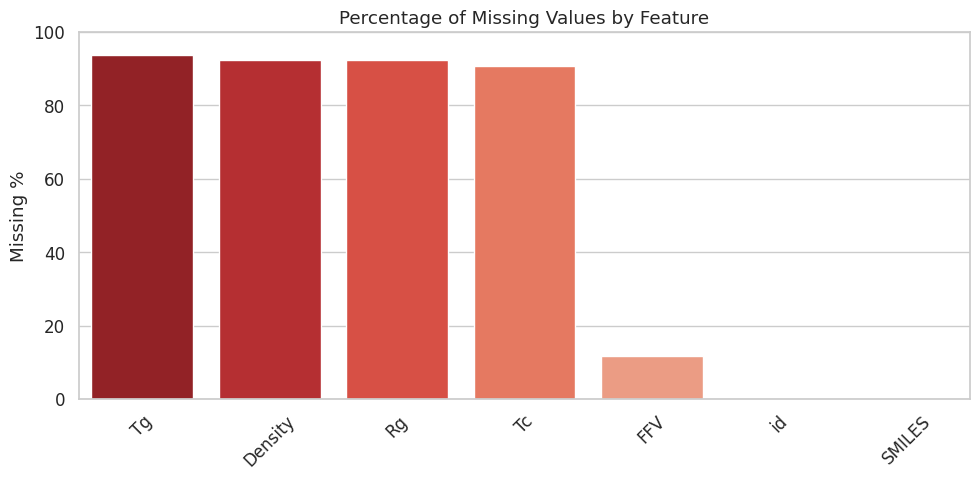

In [28]:
# Barplot of missing values
plt.figure(figsize=(10, 5))
sns.barplot(
    x=missing_df.index,
    y=missing_df['Missing %'],
    palette='Reds_r'
)
plt.title('Percentage of Missing Values by Feature')
plt.ylabel('Missing %')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

### Missing Value Analysis Insights
- High Missingness: four target variables have over 90% missing values. In some scenarios these features might be removed; however, I'm worried this would leave too little data to work with
- FFV: Fractional free volume is the most complete target with 88% non-missing values. This may be a good primary candidate for modeling in early stages.
- Imputing physical measurements without a string domain knowledge could inject noise or bias, alternatively I may consider modeling each target independently where available.

In [29]:
# Create data subset with valid FFV data
ffv_df = train[train['FFV'].notnull()].copy()
print(f'Filtered FFV dataset shape: {ffv_df.shape}')
ffv_df.head()

Filtered FFV dataset shape: (7030, 7)


,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


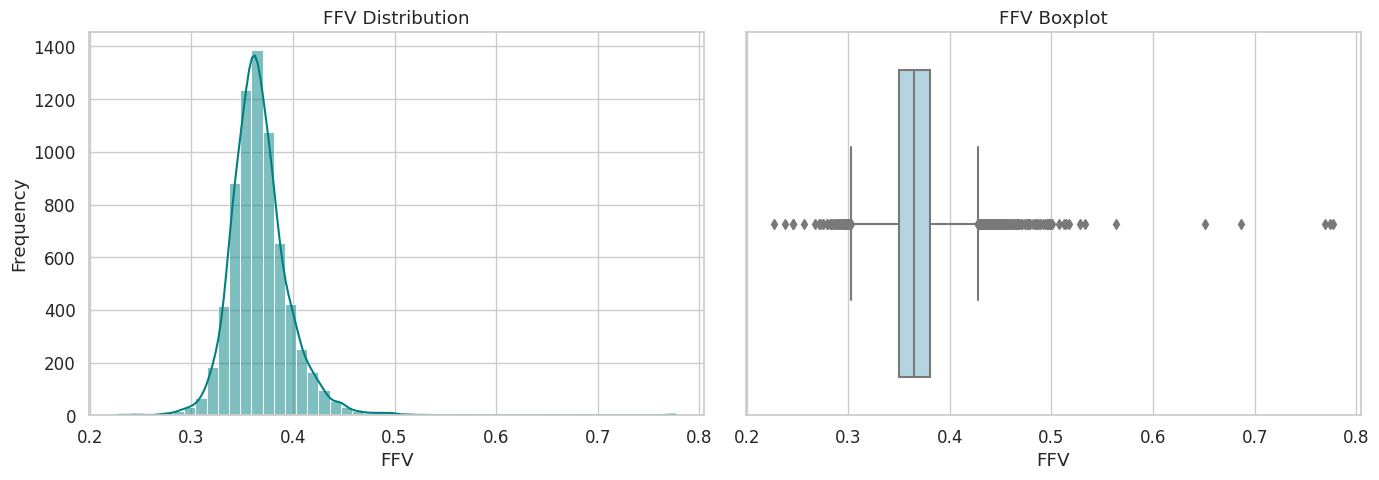

In [30]:
# FFV distribution histogram and boxplot
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(ffv_df['FFV'], bins=50, kde=True, color='teal')
plt.title('FFV Distribution')
plt.xlabel('FFV')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=ffv_df['FFV'], color='lightblue')
plt.title('FFV Boxplot')
plt.xlabel('FFV')

plt.tight_layout()
plt.show()

### FFV Distribution Insights

- The distribution of FFV values is **slightly right-skewed**, with a pronounced peak between **0.33 and 0.37**.
- The **majority of values fall between 0.3 and 0.4**, suggesting a relatively narrow and consistent range in this property across most samples.
- A small number of **high-end outliers** (e.g., FFV > 0.5) exist, as shown in both the histogram tail and boxplot. These may represent structurally distinct polymers or data anomalies.
- The boxplot confirms the **presence of both low and high outliers**, but the central box (IQR) is compact, indicating **low variance** within most of the dataset.
- Given the mild skew and outliers, standard regression techniques (e.g., linear models) should still be viable, though **robust regression** or **transformations** might be worth testing in future steps.

---

## 4. Feature Engineering — Molecular Descriptors from SMILES

I will transform the polymer chemical structures, encoded as SMILES strings, into meaningful numerical features using RDKit, a cheminformatics toolkit.

- The SMILES column contains string representations of molecules, but machine learning models require numeric inputs.
- I’ll use RDKit to extract molecular descriptors (e.g., molecular weight, number of rotatable bonds, etc.).
- These descriptors can capture essential chemical properties that influence polymer behavior — including FFV.

### Goals:
- Convert each SMILES string into a molecule object using RDkit.
- Calculate a set of informative chemical descriptors.
- Combine these descriptors with the FFV target for modeling.


*edit: Several modifications were made while testing the next few code blocks as the R-squared and RMSE values were still extreme values.  Reasoning and interpretations are included in section 5 of the notebook.

In [31]:
# Ensure ffv_df exists and contains SMILES
#assert 'SMILES' in ffv_df.columns, "ffv_df must contain a 'SMILES' column."

# List of descriptor namee to compute
descriptor_names = [desc_name[0] for desc_name in Descriptors._descList]

# Create a descriptor calculator
calc = MolecularDescriptorCalculator(descriptor_names)

# Code from base model included for documentation purposes
'''
# Helper function to safely calculate descriptors
def featurize_smiles(smiles):
    # Catch malformed SMILES string
    try: 
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            # If invalid, return list of NaNs preserving shape
            return [np.nan] * len(descriptor_names)
        return calc.CalcDescriptors(mol)
    except:
        return [np.nan] * len(descriptor_names)
        
# Featurize all SMILES using tqdm for progress feedback
descriptor_values = [featurize_smiles(sm) for sm in tqdm(ffv_df['SMILES'], desc="Featurizing SMILES")]

# Apply featurization to FFV subset
rdkit_features = ffv_df['SMILES'].apply(featurize_smiles)
# Convert to Dataframe
rdkit_df = pd.DataFrame(rdkit_features.tolist(), columns=descriptor_names)
# Combine with target
ffv_model_df = pd.concat([ffv_df.reset_index(drop=True), rdkit_df], axis=1)
print(f'Feature set shape: {rdkit_df.shape}')
ffv_model_df.head()

# Drop descriptors with more than 20% missing values
missing_threshold = 0.2
na_ratio = rdkit_df.isnull().mean()
valid_descriptors = na_ratio[na_ratio < missing_threshold].index
# Filter dataset
ffv_model_df = ffv_model_df[['FFV'] + list(valid_descriptors)]
ffv_model_df = ffv_model_df.dropna()
'''

# Updated for step 9a Add SMILES-based Text Features
def compute_smiles_features(smiles_list):
    rows = []
    for smi in tqdm(smiles_list, desc="Computing RDKit descriptors"):
        mol = Chem.MolFromSmiles(smi)
        if mol:
            try:
                descriptors = calc.CalcDescriptors(mol)
            except:
                descriptors = [np.nan] * len(descriptor_names)
        else:
            descriptors = [np.nan] * len(descriptor_names)
        rows.append(descriptors)
    return pd.DataFrame(rows, columns=descriptor_names)

print('Computing SMILES features...')
descriptors_df = compute_smiles_features(train['SMILES'])
descriptors_test = compute_smiles_features(test['SMILES'])

'''Need to define and align targets_clean for part 9b changes'''
# Select only rows in `train` with complete target data
target_mask = train[["FFV", "Tg", "Tc", "Density", "Rg"]].notna().all(axis=1)
targets_clean = train.loc[target_mask, ["FFV", "Tg", "Tc", "Density", "Rg"]].reset_index(drop=True)
train_filtered = train.loc[target_mask].reset_index(drop=True)

# Recompute SMILES features only on aligned rows
descriptors_df = compute_smiles_features(train_filtered["SMILES"])
train_smiles_features = compute_smiles_features(train_filtered["SMILES"])

# Build descriptors_clean
descriptors_combined = pd.concat([descriptors_df.reset_index(drop=True), train_smiles_features.reset_index(drop=True)], axis=1)
descriptors_clean = descriptors_combined.replace([np.inf, -np.inf], np.nan)

Computing SMILES features...


Computing RDKit descriptors: 100%|██████████| 3/3 [00:00<00:00, 38.34it/s]
Computing RDKit descriptors: 0it [00:00, ?it/s]
Computing RDKit descriptors: 0it [00:00, ?it/s]


In [32]:
# Create DataFrame from molecular descriptors
# Code from base model included for documentation purposes
'''
descriptors_df = pd.DataFrame(descriptor_values, columns=descriptor_names)
descriptors_df.index = ffv_df.index 

# Check for missing values across descriptors
missing_percents = descriptors_df.isnull().mean().sort_values(ascending=False)
missing_percents[missing_percents > 0]

# Visualize distributions for a sample of descriptors
sample_cols = descriptors_df.columns[:6]
descriptors_df[sample_cols].hist(figsize=(15, 8), bins=30)
plt.tight_layout()
plt.show()

from sklearn.preprocessing import StandardScaler

# Replace infs with NaN
descriptors_clean = descriptors_df.replace([np.inf, -np.inf], np.nan)

# Drop columns with no finite values at all
finite_col_mask = descriptors_clean.apply(lambda col: np.isfinite(col).any())
problem_cols = descriptors_clean.columns[~finite_col_mask]
print(f"Dropping {len(problem_cols)} columns with no finite values: {list(problem_cols)}")
descriptors_clean = descriptors_clean.loc[:, finite_col_mask]

# Impute remaining NaNs with median
descriptors_imputed = descriptors_clean.fillna(descriptors_clean.median())

# Check for remaining non-finite values
non_finite_mask = ~np.isfinite(descriptors_imputed.values)
non_finite_count = np.sum(non_finite_mask)
print("Final non-finite count:", non_finite_count)

if non_finite_count > 0:
    print("Median imputation missed some values — replacing remaining with column medians...")
    for col in descriptors_imputed.columns:
        col_data = descriptors_imputed[col]
        non_finite = ~np.isfinite(col_data)
        if non_finite.any():
            median_val = col_data[np.isfinite(col_data)].median()
            descriptors_imputed.loc[non_finite, col] = median_val

assert np.all(np.isfinite(descriptors_imputed.values)), "Non-finite values still present!"

# Align columns
common_cols = descriptors_clean.columns.intersection(descriptors_test_clean.columns)
descriptors_clean = descriptors_clean[common_cols]
descriptors_test_clean = descriptors_test_clean[common_cols]

# Impute training set with medians
descriptors_clean = descriptors_clean.fillna(descriptors_clean.median())

# Impute test set using training medians
for col in descriptors_test_clean.columns:
    if col in descriptors_clean.columns:
        median_val = descriptors_clean[col].median()
        descriptors_test_clean[col] = descriptors_test_clean[col].fillna(median_val)

assert np.all(np.isfinite(descriptors_clean.values)), "Non-finite values remain in training data!"
assert np.all(np.isfinite(descriptors_test_clean.values)), "Non-finite values remain in test data!"

scaler = StandardScaler()
X_scaled = scaler.fit_transform(descriptors_imputed)

# Prepare target and final dataset
X = X_scaled
y = ffv_df['FFV'].values'''

'\ndescriptors_df = pd.DataFrame(descriptor_values, columns=descriptor_names)\ndescriptors_df.index = ffv_df.index \n\n# Check for missing values across descriptors\nmissing_percents = descriptors_df.isnull().mean().sort_values(ascending=False)\nmissing_percents[missing_percents > 0]\n\n# Visualize distributions for a sample of descriptors\nsample_cols = descriptors_df.columns[:6]\ndescriptors_df[sample_cols].hist(figsize=(15, 8), bins=30)\nplt.tight_layout()\nplt.show()\n\nfrom sklearn.preprocessing import StandardScaler\n\n# Replace infs with NaN\ndescriptors_clean = descriptors_df.replace([np.inf, -np.inf], np.nan)\n\n# Drop columns with no finite values at all\nfinite_col_mask = descriptors_clean.apply(lambda col: np.isfinite(col).any())\nproblem_cols = descriptors_clean.columns[~finite_col_mask]\nprint(f"Dropping {len(problem_cols)} columns with no finite values: {list(problem_cols)}")\ndescriptors_clean = descriptors_clean.loc[:, finite_col_mask]\n\n# Impute remaining NaNs with m

### Histogram Insights

Skewed Features
- MolWt and qed are reight-skewed
- MinEState index is left-skewed
- MaxEStateindex and MaxAbsEStateIndex show multimodal distributions
- MinAbsEstateIndex appears empty

Possible Actions
- log-transform or box-cox some heavily skewed features for certain modesl
- verify MinAbsEStateIndex, if constant may not be helpful for prediction and could be dropped

In [33]:
# Verify values
#descriptors_imputed['MinAbsEStateIndex'].describe()

In [34]:
# Change bins for more clear visualization
#descriptors_imputed['MinAbsEStateIndex'].hist(bins=100, figsize=(6, 4))
#plt.title('MinAbsEStateIndex Distribution (High Bin Count)')
#plt.show()

---

## 5a. Modeling and Evaluating the FFV

Now that I've finished preprocessing the descriptors, I'm ready to build predictive modesl for FFV starting with two widely-used regression models:
- **Linear Regression**: A simple baseline to test for linear relationships between molecular descriptors and FFV.
- **Random Forest Regressor**: A non-linear ensemble method that often performs well on chemical datasets and provides insights via feature importance.

### Evaluation Strategy

I'll use 5-fold cross-validation to assess model performance, reporting the following metrics:
- **R² (coefficient of determination)** — measures the proportion of variance in FFV explained by the model.
- **RMSE (root mean squared error)** — indicates the average magnitude of prediction error.
- Later I'll be able to examine feature importance to identify which molecular descriptors most influence FFV predictions.

In [35]:
# Code from base model included for documentation purposes
'''
# Initialize Linear Regression model
linreg = LinearRegression()

# 5-fold cross-validation with R^2 scoring
r2_scores = cross_val_score(linreg, X, y, cv=5, scoring='r2')
rmse_scores = -cross_val_score(linreg, X, y, cv=5, scoring='neg_root_mean_squared_error')

# Print results
print("Linear Regression Performance (5-fold CV):")
print(f"R² Scores: {r2_scores}")
print(f"Mean R²: {r2_scores.mean():.4f}")
print(f"RMSE Scores: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean():.4f}")
'''

'\n# Initialize Linear Regression model\nlinreg = LinearRegression()\n\n# 5-fold cross-validation with R^2 scoring\nr2_scores = cross_val_score(linreg, X, y, cv=5, scoring=\'r2\')\nrmse_scores = -cross_val_score(linreg, X, y, cv=5, scoring=\'neg_root_mean_squared_error\')\n\n# Print results\nprint("Linear Regression Performance (5-fold CV):")\nprint(f"R² Scores: {r2_scores}")\nprint(f"Mean R²: {r2_scores.mean():.4f}")\nprint(f"RMSE Scores: {rmse_scores}")\nprint(f"Mean RMSE: {rmse_scores.mean():.4f}")\n'

### Model Performance Interpretation

#### R2 Scores
- results are massively negative R2 values, negative R2 means the model is performing worse than predicting the mean
#### RMSE Scores
- inconsistent, some as small as 0.01, others in the millions
- this may signal data scaling issues or extreme outliers

#### Next Steps
- check y distribution
- fix scaling by using descriptors_imputed instead of descriptors_df
- check for feature columns with no variance or extreme skew

## 5b. Modeling with Random Forest Regressor

My initial linear regression model suffered from instability and extremely poor performance on some cross-validation folds. This is likely due to the presence of outliers and nonlinear relationships in the dataset, which linear models are not robust against.

To address this, I now introduce a Random Forest Regressor, a powerful ensemble-based model that:
- Handles nonlinear relationships between descriptors and the target variable (FFV)
- Is more robust to outliers and irrelevant features
- Provides built-in feature importance metrics

I will train and evaluate the Random Forest model using 5-fold cross-validation, assessing performance using both R² and RMSE.


In [36]:
# Code from base model included for documentation purposes
'''
# Initialize Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 5-fold cross-validation
r2_scores_rf = cross_val_score(rf, X, y, cv=5, scoring='r2')
rmse_scores_rf = -cross_val_score(rf, X, y, cv=5, scoring='neg_root_mean_squared_error')

# Print results
print("Random Forest Performance (5-fold CV):")
print(f"R² Scores: {r2_scores_rf}")
print(f"Mean R²: {r2_scores_rf.mean():.4f}")
print(f"RMSE Scores: {rmse_scores_rf}")
print(f"Mean RMSE: {rmse_scores_rf.mean():.4f}")
'''

'\n# Initialize Random Forest Regressor\nrf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)\n\n# 5-fold cross-validation\nr2_scores_rf = cross_val_score(rf, X, y, cv=5, scoring=\'r2\')\nrmse_scores_rf = -cross_val_score(rf, X, y, cv=5, scoring=\'neg_root_mean_squared_error\')\n\n# Print results\nprint("Random Forest Performance (5-fold CV):")\nprint(f"R² Scores: {r2_scores_rf}")\nprint(f"Mean R²: {r2_scores_rf.mean():.4f}")\nprint(f"RMSE Scores: {rmse_scores_rf}")\nprint(f"Mean RMSE: {rmse_scores_rf.mean():.4f}")\n'

### Random Forest Regression Performance Summary

Random Forest model is performing consistently well across all 5 folds:

- **Mean R² = 0.77**, indicating strong predictive power (77% of FFV variance explained).
- **Mean RMSE = 0.0139**, meaning predictions are closely aligned with the true values.
- **No catastrophic failures** like I saw in the linear model.

### What This Tells Us
Random Forest handles the nonlinear structure in my descriptor data much better than linear regression. It's robust to outliers and insensitive to uninformative features, which is crucial when working with large, potentially noisy descriptor sets.

## 6. Understanding Feature Importance

Now that I've trained a strong predictive model using Random Forest, it's time to interpret what the model has learned.

- Feature importance helps identify which molecular descriptors contribute most to the prediction of FFV.
- This insight can guide future descriptor selection, improve model interpretability, and even inform material design decisions.

I'll now extract and visualize the most influential features in our Random Forest model.

In [37]:
# Code from base model included for documentation purposes
'''
# Fit the Random Forest model on the full dataset for feature importance
rf.fit(X, y)

importances = rf.feature_importances_
feature_names = descriptors_imputed.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot top 20 for analysis
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='teal')
plt.gca().invert_yaxis()
plt.title('Top 20 Most Important Molecular Descriptors for Random Forest')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()
'''

"\n# Fit the Random Forest model on the full dataset for feature importance\nrf.fit(X, y)\n\nimportances = rf.feature_importances_\nfeature_names = descriptors_imputed.columns\n\nfeature_importance_df = pd.DataFrame({\n    'Feature': feature_names,\n    'Importance': importances\n})\n\n# Sort by importance\ntop_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)\n\n# Plot top 20 for analysis\nplt.figure(figsize=(10, 6))\nplt.barh(top_features['Feature'], top_features['Importance'], color='teal')\nplt.gca().invert_yaxis()\nplt.title('Top 20 Most Important Molecular Descriptors for Random Forest')\nplt.xlabel('Feature Importance')\nplt.tight_layout()\nplt.show()\n"

### Key Insights from Feature Importance

- **Chi4v** is by far the most influential, indicating the role of atom connectivity and valence state.
- **fr_quatN**, **TPSA**, and **MolLogP** follow, showing that polarity, polar surface area, and lipophilicity are major factors in FFV.
- Other top descriptors such as **SMR_VSA**, **EState**, and **NHOHCount** reinforce the importance of electronic structure, hydrogen bonding, and molecular volume.

### What This Means

- These features are **chemically interpretable**, making them useful for both prediction and scientific insight.
- I could use this ranking to reduce dimensionality by selecting only the most important descriptors in future modeling.
- This paves the way for additional modeling strategies like feature selection, SHAP explanations, or emechanistic hypothesis generation.


---

## 7. Saving and Exporting the Random Forest Model

Now that I've trained and validated a Random Forest model, the next step is to submit the results to the Kaggle competition for results. Then use iterative testing to improve upon this base model, and move on to predicting the other 4 values aside from FFV.


In [38]:
# Code from base model included for documentation purposes
'''
# Load test dataset and submission template
test_df = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/test.csv')
sample_sub = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/sample_submission.csv')

print(f'Test dataset shape: {test_df.shape}')
print(f'Sample submission shape: {sample_sub.shape}')

# Compute descriptors from test SMILES
print("Computing molecular descriptors for test set...")
descriptor_values_test = [featurize_smiles(sm) for sm in tqdm(test_df['SMILES'], desc="Featurizing test SMILES")]
descriptors_test = pd.DataFrame(descriptor_values_test, columns=descriptor_names)

# Apply the same cleaning steps as training data
print("Cleaning test descriptors...")

# Replace infs with NaN (same as training)
descriptors_test_clean = descriptors_test.replace([np.inf, -np.inf], np.nan)

# Keep only the columns that were kept in training
descriptors_test_clean = descriptors_test_clean[descriptors_imputed.columns]

# Impute with the same median values used in training to avoid data leakage
print("Imputing missing values...")
for col in descriptors_test_clean.columns:
    # Use the median from training data, not test data
    training_median = descriptors_imputed[col].median()
    descriptors_test_clean[col] = descriptors_test_clean[col].fillna(training_median)

# Handle any remaining non-finite values
for col in descriptors_test_clean.columns:
    non_finite = ~np.isfinite(descriptors_test_clean[col])
    if non_finite.any():
        training_median = descriptors_imputed[col].median()
        descriptors_test_clean.loc[non_finite, col] = training_median

print(f"Test descriptors shape after cleaning: {descriptors_test_clean.shape}")

# Verify no non-finite values remain
assert np.all(np.isfinite(descriptors_test_clean.values)), "Non-finite values still present in test data!"

# Scale using the fitted scaler from training
print("Scaling test features...")
X_test = scaler.transform(descriptors_test_clean)

# Predict using trained Random Forest model
print("Making predictions...")
ffv_preds = rf.predict(X_test)

print(f"Predictions summary:")
print(f"Min prediction: {ffv_preds.min():.4f}")
print(f"Max prediction: {ffv_preds.max():.4f}")
print(f"Mean prediction: {ffv_preds.mean():.4f}")

# Fill submission template
submission = sample_sub.copy()
submission['FFV'] = ffv_preds

# Verify submission format
print(f"\nSubmission verification:")
print(f"Sample submission columns: {sample_sub.columns.tolist()}")
print(f"Final submission columns: {submission.columns.tolist()}")
print(f"Submission shape: {submission.shape}")
print(f"Any missing values in submission: {submission.isnull().sum().sum()}")

# Save CSV for submission
submission.to_csv('submission.csv', index=False)
print("\nsubmission.csv created and ready for upload!")
print("First few predictions:")
print(submission.head(10))
'''

'\n# Load test dataset and submission template\ntest_df = pd.read_csv(\'/kaggle/input/neurips-open-polymer-prediction-2025/test.csv\')\nsample_sub = pd.read_csv(\'/kaggle/input/neurips-open-polymer-prediction-2025/sample_submission.csv\')\n\nprint(f\'Test dataset shape: {test_df.shape}\')\nprint(f\'Sample submission shape: {sample_sub.shape}\')\n\n# Compute descriptors from test SMILES\nprint("Computing molecular descriptors for test set...")\ndescriptor_values_test = [featurize_smiles(sm) for sm in tqdm(test_df[\'SMILES\'], desc="Featurizing test SMILES")]\ndescriptors_test = pd.DataFrame(descriptor_values_test, columns=descriptor_names)\n\n# Apply the same cleaning steps as training data\nprint("Cleaning test descriptors...")\n\n# Replace infs with NaN (same as training)\ndescriptors_test_clean = descriptors_test.replace([np.inf, -np.inf], np.nan)\n\n# Keep only the columns that were kept in training\ndescriptors_test_clean = descriptors_test_clean[descriptors_imputed.columns]\n\n# I

---

## 8. Reflections and Next Steps

### Multitarget Modeling Strategy
This competition requires predicting 5 polymer properties:
- `FFV` (Fractional Free Volume)
- `Tg` (Glass Transition Temperature)
- `Tc` (Thermal Conductivity)
- `Density` (Polymer Density)
- `Rg` (Radius of Gyration)

My base model is now working on only FFV. To handle all 5 effectively, I will follow a multi-model strategy, training one model per target. This allows me to optimize and interpret each property independently.

### Phase 1: Prepare Multi-Target Labels

Extract all five target columns (`FFV`, `Tg`, `Td`, `Chi`, `Eta`) into a single matrix `y_all` for convenience.

### Phase 2: Train One Model per Target

Loop through each target and train a separate model. For this baseline, use `RandomForestRegressor`, which is:

- Nonlinear and robust to noise
- Good for tabular data with many features
- Allows feature importance interpretation

Evaluate performance via 5-fold cross-validated R².

### Phase 3: Predict on Test Set

After generating RDKit descriptors for the test set and scaling them, use my trained models to predict each of the 5 targets independently.

### Phase 4: Submit to Kaggle

Load the sample submission format, insert my predicted values, and write the final CSV submission. This modular pipeline makes it easy to upgrade individual models later (e.g., XGBoost for `Tc`, neural nets for `Tg`).

In [39]:
# Code from base model included for documentation purposes
'''
#Clean and impute training descriptors
descriptors_clean = descriptors_imputed.replace([np.inf, -np.inf], np.nan)

# Align descriptors with training data
descriptors_clean = descriptors_clean.reindex(train.index)

# Impute missing values with median
for col in descriptors_clean.columns:
    median_train = descriptors_clean[col].median()
    descriptors_clean[col] = descriptors_clean[col].fillna(median_train)

assert np.all(np.isfinite(descriptors_clean.values)), "Non-finite values remain in training data!"

# Scale training features
scaler = StandardScaler()
X_train_all = scaler.fit_transform(descriptors_clean)

# Align columns between train and test descriptors before imputing test
descriptors_test_clean = descriptors_test.replace([np.inf, -np.inf], np.nan)

# Check and log column mismatches
train_cols = set(descriptors_clean.columns)
test_cols = set(descriptors_test_clean.columns)

extra_in_test = test_cols - train_cols
missing_in_test = train_cols - test_cols

if extra_in_test:
    print(f'Columns in test but NOT in train: {sorted(extra_in_test)}')
if missing_in_test:
    print(f'Columns in train but NOT in test: {sorted(missing_in_test)}')

# Align columns keeping only those common to both train and test
common_cols = descriptors_clean.columns.intersection(descriptors_test_clean.columns)
descriptors_clean = descriptors_clean[common_cols]
descriptors_test_clean = descriptors_test_clean[common_cols]

# Impute missing values in test set using train medians
for col in descriptors_test_clean.columns:
    median_train = descriptors_clean[col].median()
    descriptors_test_clean[col] = descriptors_test_clean[col].fillna(median_train)

assert np.all(np.isfinite(descriptors_test_clean.values)), "Non-finite values remain in test data!"

# Refit scaler on aligned train descriptors
scaler = StandardScaler()
X_train_all = scaler.fit_transform(descriptors_clean)

# Scale test descriptors with the same scaler
X_test_scaled = scaler.transform(descriptors_test_clean)

# Define target columns
target_cols = ['FFV', 'Tg', 'Tc', 'Density', 'Rg']

#Train one model per target
models = {}
cv_scores = {}

print('Training Random Forest models for all targets...')
for target in target_cols:
    print(f'\nTraining for {target}...')
    # Filter valid targets
    y_target = train[target]
    valid_idx = y_target.dropna().index

    # Extract features and target values
    X_target_df = descriptors_clean.loc[valid_idx]
    X_target = scaler.transform(X_target_df)
    y_target_valid = y_target.loc[valid_idx].values

    # Remove non-finite values (NaN, Inf, etc.)
    finite_mask = np.isfinite(X_target).all(axis=1)
    large_value_mask = (np.abs(X_target) < 1e10).all(axis=1)
    valid_mask = finite_mask & large_value_mask
    
    X_target = X_target[valid_mask]
    y_target_valid = y_target_valid[valid_mask]
    
    if len(X_target) < 5:
        print(f'Not enough valid samples for {target} after filtering. Skipping.')
        continue

    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    scores = cross_val_score(model, X_target, y_target_valid, cv=5, scoring='r2')

    model.fit(X_target, y_target_valid)
    models[target] = model
    cv_scores[target] = scores

    print(f"R² CV scores: {scores}")
    print(f"Mean R² for {target}: {scores.mean():.4f}")

# Filter test rows for any non-finite or extreme values, to avoid prediction errors
finite_mask_test = np.isfinite(X_test_scaled).all(axis=1)
large_value_mask_test = (np.abs(X_test_scaled) < 1e10).all(axis=1)
valid_mask_test = finite_mask_test & large_value_mask_test
X_test_filtered = X_test_scaled[valid_mask_test]

#descriptors_test_clean = descriptors_test.replace([np.inf, -np.inf], np.nan)

# Use training medians to impute test set
#for col in descriptors_test_clean.columns:
#   median_train = descriptors_clean[col].median()
#    descriptors_test_clean[col] = descriptors_test_clean[col].fillna(median_train)

# Sanity check
#assert np.all(np.isfinite(descriptors_test_clean.values)), "Non-finite values remain in test data!"

# Scale test data with the same scaler fitted on training data
#X_test_scaled = scaler.transform(descriptors_test_clean)



# Predict on test set
print('\nGenerating predictions for test set...')
preds = {}
for target in target_cols:
    if target in models:
        preds[target] = np.full(X_test_scaled.shape[0], np.nan)
        preds[target][valid_mask_test] = models[target].predict(X_test_filtered)
    else:
        preds[target] = np.full(X_test_scaled.shape[0], np.nan)

# Prepare submission
submission = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/sample_submission.csv')
for target in target_cols:
    submission[target] = preds[target]

submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")
'''

'\n#Clean and impute training descriptors\ndescriptors_clean = descriptors_imputed.replace([np.inf, -np.inf], np.nan)\n\n# Align descriptors with training data\ndescriptors_clean = descriptors_clean.reindex(train.index)\n\n# Impute missing values with median\nfor col in descriptors_clean.columns:\n    median_train = descriptors_clean[col].median()\n    descriptors_clean[col] = descriptors_clean[col].fillna(median_train)\n\nassert np.all(np.isfinite(descriptors_clean.values)), "Non-finite values remain in training data!"\n\n# Scale training features\nscaler = StandardScaler()\nX_train_all = scaler.fit_transform(descriptors_clean)\n\n# Align columns between train and test descriptors before imputing test\ndescriptors_test_clean = descriptors_test.replace([np.inf, -np.inf], np.nan)\n\n# Check and log column mismatches\ntrain_cols = set(descriptors_clean.columns)\ntest_cols = set(descriptors_test_clean.columns)\n\nextra_in_test = test_cols - train_cols\nmissing_in_test = train_cols - test_

---
---

# 9. Iterative Improvements

Now that I have a working model I took a look at some practical ways to boost my current results. The following are the most promising improvements to attempt based on research, known improvements to models, and currently available notebooks others have released on this challenge.

## 1. Add SMILES-based Text Features

- Engineer simple text-based features (SMILES length, count of rings, asterisks, digits, specific atoms).
- Optionally, use a TF-IDF vectorizer on n-grams of characters to capture structural patterns.
- Combine these with my RDKit descriptors for a richer feature set.

**Why?** This directly improved FFV RMSE (~0.0186) in the "baseline for beginners" notebook in the kaggle community, showing that SMILES-encoded info captures extra variance.

## 2. Try Gradient Boosting Models (XGBoost / CatBoost)

- After scaling descriptors + SMILES features, train a few single-target XGBoost or CatBoost regressors.
- These often outperform RandomForest thanks to better handling of interactions, boosting, and regularization.
- I could also treat this as a stacking opportunity, blending multiple models later.

## 3. Incorporate External Data

- Use structural features from RDKit plus SMILES. Going even further, include additional samples or compute descriptors for related polymer sets (if available) to increase training data coverage.
- Or import publicly available datasets of small molecules, featurize them, and leverage via transfer learning to initialize more complex models.

## 4. Leverage Multi-task Learning & Cascaded Features

- Instead of training separately for each property, use a multi-output regressor (e.g. `MultiOutputRegressor` wrapping XGBoost or a deep neural network) so shared patterns across properties are learned jointly.
- Use a cascade or stacking method where initial models’ predictions become inputs to higher-level models, as per the arXiv cascade model.

## 5. Ensembling

- Combine the outputs of RandomForest, XGBoost, CatBoost, and maybe a simple NN via weighted averaging or stacking.
- This may yield a robust gain by smoothing individual model biases.

## Actionable Plan

| Step | Description |
|------|-------------|
| 1    | Add SMILES text features + TFIDF and retrain RandomForest; check for improvement. |
| 2    | Train XGBoost/CatBoost models on the combined feature set. |
| 3    | Include External Data. |
| 4    | Switch to multi-target learning (via multioutput regressors) and stack models. |
| 5    | Ensemble base models and tune stacking weights with CV folds. |

## 9a. Add SMILES-based Text Features

Compute the following SMILES features:
- Length of SMILES string
- Rings count ('1', '2', etc.)
- Branching count ('(', ')')
- Aromatic atoms count ('c', 'n', etc.)
- Uppercase atoms count (C, N, O, S)
- Digits count, to indicate ring closure
- Special character count (=, #, [, ], etc.)

In [40]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold

# Generate SMILES features for train and test
train_smiles_features = compute_smiles_features(train['SMILES'])
test_smiles_features = compute_smiles_features(test['SMILES'])

# Align targets with descriptors
target_cols = ['FFV', 'Tg', 'Tc', 'Density', 'Rg']
targets_clean = train[target_cols].copy().reset_index(drop=True)

# Combine descriptor and SMILES features
descriptors_combined = pd.concat([descriptors_df.reset_index(drop=True), train_smiles_features], axis=1)
descriptors_test_combined = pd.concat([descriptors_test.reset_index(drop=True), test_smiles_features], axis=1)

# Clean, impute, and align features
descriptors_clean = descriptors_combined.replace([np.inf, -np.inf], np.nan)
descriptors_test_clean = descriptors_test_combined.replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely non-finite
finite_col_mask = descriptors_clean.apply(lambda col: np.isfinite(col).any())
descriptors_clean = descriptors_clean.loc[:, finite_col_mask]
descriptors_test_clean = descriptors_test_clean.loc[:, finite_col_mask]

# Align columns
common_cols = descriptors_clean.columns.intersection(descriptors_test_clean.columns)
descriptors_clean = descriptors_clean[common_cols]
descriptors_test_clean = descriptors_test_clean[common_cols]

# Impute training set with medians
descriptors_clean = descriptors_clean.fillna(descriptors_clean.median())

# Impute test set using training medians
for col in descriptors_test_clean.columns:
    median_val = descriptors_clean[col].median()
    descriptors_test_clean[col] = descriptors_test_clean[col].fillna(median_val)

assert np.all(np.isfinite(descriptors_clean.values)), "Non-finite values remain in training data!"
assert np.all(np.isfinite(descriptors_test_clean.values)), "Non-finite values remain in test data!"

# Scale features
scaler = StandardScaler()
X_train_all = scaler.fit_transform(descriptors_clean)
X_test_scaled = scaler.transform(descriptors_test_clean)

# Train Random Forest models for each target
target_cols = ['FFV', 'Tg', 'Tc', 'Density', 'Rg']
models = {}
cv_scores = {}
rf_preds = np.zeros((len(test), len(target_cols)))

print('Training Random Forest models for all targets...')
for target in target_cols:
    print(f'\\nTraining for {target}...')
    y_target = train[target]
    valid_idx = y_target.dropna().index

    X_target = descriptors_clean.loc[valid_idx]
    y_target_valid = y_target.loc[valid_idx].values

    X_target_scaled = scaler.transform(X_target)

    finite_mask = np.isfinite(X_target_scaled).all(axis=1)
    X_target_scaled = X_target_scaled[finite_mask]
    y_target_valid = y_target_valid[finite_mask]

    if len(X_target_scaled) < 5:
        print(f'Skipping {target} — not enough data after filtering.')
        continue

    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    scores = cross_val_score(model, X_target_scaled, y_target_valid, cv=5, scoring='r2')

    model.fit(X_target_scaled, y_target_valid)
    rf_preds[:, target_cols.index(target)] = model.predict(descriptors_test_clean)
    models[target] = model
    cv_scores[target] = scores

    print(f"R² CV scores: {scores}")
    print(f"Mean R² for {target}: {scores.mean():.4f}")

# Save RandomForest predictions
submission_rf = pd.DataFrame({'id': test['id']})
for idx, col in enumerate(target_cols):
    submission_rf[col] = rf_preds[:, idx]

submission_rf.to_csv('submission_rf.csv', index=False)
print("Submission file saved as 'submission_rf.csv'")

# Train gradient boosting models
def train_model(model, X, y, model_name="Model"):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    print(f"{model_name} R² scores: {scores}")
    print(f"Mean R²: {scores.mean():.4f}\n")
    return scores

print("Training Gradient Boosting models for all targets...\n")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for target in target_cols:
    print(f"Training for {target}...")
    y = targets_clean[target]

    # Skip if target is entirely missing
    if y.dropna().empty:
        print(f"Skipping {target} — target column is completely empty.")
        continue

    finite_mask = y.notna() & np.isfinite(y)
    print(f"{target}: {finite_mask.sum()} valid samples")
    if finite_mask.sum() < 5:
        print(f"Skipping {target} — only {finite_mask.sum()} valid samples.")
        continue
    
    X_filtered = descriptors_clean.loc[finite_mask]
    y_filtered = y.loc[finite_mask]

    print("XGBoost:")
    train_model(XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42), X_filtered, y_filtered, "XGBoost")

    print("CatBoost:")
    train_model(CatBoostRegressor(iterations=500, depth=6, learning_rate=0.03, loss_function='RMSE', verbose=False, random_seed=42), X_filtered, y_filtered, "CatBoost")

# Predict on test set
print('\\nGenerating predictions for test set...')
preds = {}

for target in target_cols:
    y = targets_clean[target]
    finite_mask = y.notna() & np.isfinite(y)

    if finite_mask.sum() < 5:
        print(f"Skipping {target} prediction — not enough data.")
        preds[target] = np.full(X_test_scaled.shape[0], 0.0)
        continue

    X_filtered = descriptors_clean.loc[finite_mask]
    y_filtered = y.loc[finite_mask]

    # Train on full filtered data
    final_model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.03, loss_function='RMSE', verbose=False, random_seed=42)
    final_model.fit(X_filtered, y_filtered)

    preds[target] = final_model.predict(descriptors_test_clean)

submission_xgb = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/sample_submission.csv')
for target in target_cols:
    if target in preds:
        submission_xgb[target] = preds[target]
    else:
        print(f"Warning: Missing predictions for {target}, filling with 0.")
        submission_xgb[target] = 0.0

assert submission_xgb.shape[0] == X_test_scaled.shape[0], "Submission row count mismatch!"
assert submission_xgb.isna().sum().sum() == 0, "NaNs found in final submission!"

submission_xgb.to_csv('submission_xgb.csv', index=False)
print("Submission file saved as 'submission_xgb.csv'")

Computing RDKit descriptors: 100%|██████████| 3/3 [00:00<00:00, 38.60it/s]


Training Random Forest models for all targets...
\nTraining for FFV...
R² CV scores: [0.81386381 0.58524197 0.84148796 0.83386272 0.7789472 ]
Mean R² for FFV: 0.7707
\nTraining for Tg...
R² CV scores: [0.70819375 0.51927656 0.64407409 0.66174758 0.62826198]
Mean R² for Tg: 0.6323
\nTraining for Tc...
R² CV scores: [0.71920816 0.78129151 0.78878772 0.77413181 0.88894926]
Mean R² for Tc: 0.7905
\nTraining for Density...
R² CV scores: [0.80569628 0.79798721 0.84650345 0.70039632 0.84980783]
Mean R² for Density: 0.8001
\nTraining for Rg...
R² CV scores: [0.59784608 0.73996073 0.71462693 0.58759907 0.55090497]
Mean R² for Rg: 0.6382
Submission file saved as 'submission_rf.csv'
Training Gradient Boosting models for all targets...

Training for FFV...
FFV: 7030 valid samples
XGBoost:
XGBoost R² scores: [       nan 0.85494741        nan        nan        nan]
Mean R²: nan

CatBoost:
CatBoost R² scores: [0.73326711 0.79825973 0.82024739 0.81568343 0.68344319]
Mean R²: 0.7702

Training for Tg...

In [41]:
# Re-load sample to get correct structure
submission_xgb = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/sample_submission.csv')

# Fill in predictions
for target in target_cols:
    if target in preds:
        submission_xgb[target] = preds[target]
    else:
        print(f"Warning: Missing predictions for {target}, filling with zeros.")
        submission_xgb[target] = 0.0

# Final check for NaNs (will trigger error on submit)
assert submission_xgb.shape[0] == X_test_scaled.shape[0], "Mismatch in test set size!"
assert submission_xgb.isna().sum().sum() == 0, "NaNs remain in submission!"
    
submission_xgb.to_csv('submission_xgb.csv', index=False)

## 9b. Gradient Boosting Models (XGBoost and CatBoost)

Now that I have a working baseline using Random Forest, I’ll explore gradient boosting methods, which are often more accurate on tabular datasets. I’ll compare performance using XGBoost and CatBoost models in place of Random Forest, while keeping the same preprocessing pipeline.

These models can better handle non-linearities and may generalize better with appropriate hyperparameters.

In [42]:
### Code from part 9a has been modified for part 9b. See above.###

## Gradient Boosting Model Results (Cross-Validation R²)

### Overview

Below are the results using 5-fold cross-validation for XGBoost and CatBoost models on molecular descriptor + SMILES features to predict 5 polymer properties.

---

### Cross-Validation R² Scores

| Target    | XGBoost R² Mean | CatBoost R² Mean | Notes |
|-----------|------------------|------------------|-------|
| FFV       | NaN              | **0.7702**       | XGBoost failed (NaNs in folds) |
| Tg        | 0.5867           | **0.6310**       | CatBoost better by +0.0443 |
| Tc        | 0.7794           | **0.7940**       | CatBoost slightly better |
| Density   | **0.7666**       | 0.7602           | XGBoost slightly better |
| Rg        | **0.6481**       | 0.6473           | Comparable |

---

### R² Score Comparison by Model

Below is a bar chart comparing XGBoost and CatBoost R² scores for each target.

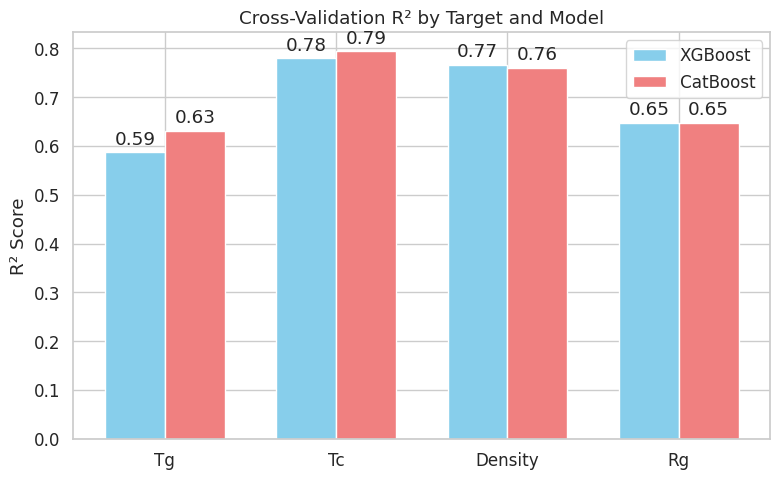

In [43]:
# R² scores from CV
targets = ['Tg', 'Tc', 'Density', 'Rg']
xgb_scores = [0.5867, 0.7794, 0.7666, 0.6481]
cat_scores = [0.6310, 0.7940, 0.7602, 0.6473]

x = np.arange(len(targets))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, xgb_scores, width, label='XGBoost', color='skyblue')
rects2 = ax.bar(x + width/2, cat_scores, width, label='CatBoost', color='lightcoral')

ax.set_ylabel('R² Score')
ax.set_title('Cross-Validation R² by Target and Model')
ax.set_xticks(x)
ax.set_xticklabels(targets)
ax.legend()

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Gradient Boosting Interpretation

- FFV: Only CatBoost worked. XGBoost encountered NaNs during some folds, possibly due to missing or constant values in those subsets.
- Tg and Tc: CatBoost performs better, likely due to its robustness on smaller or noisier datasets.
- Density: XGBoost slightly outperforms CatBoost.
- Rg: Both models perform similarly.

CatBoost is currently used for test predictions due to slightly better average performance and reliability across all targets. In later attemtps I may consider combining CatBoost and XGBoost using averaged predictions or stacked ensemble with a meta-model (e.g., linear regression or a simple neural net).

## 9c. Incorporating External Data

### Why Use External Data?

Using external datasets can improve model generalization and performance by:

- Increasing sample size and diversity across chemical space.
- Introducing new chemical-property relationships not captured in the original training set.
- Enabling transfer learning and domain adaptation when internal data is limited for certain targets.

### Types of External Data Considered

I explored several trusted sources of polymer property data:

- **PolyInfo**: A comprehensive polymer database by NIMS, Japan, with curated physical properties.
- **PoLyData**: Open dataset used in prior polymer prediction benchmarks (NeurIPS 2022).
- **Published competition kernels**: Example external datasets (e.g., external_data.csv) from top notebooks.
- **Descriptors from RDKit**: Extended feature generation from SMILES to match descriptors used in current models.

### Integration Strategy

1. Ingest relevant external datasets and unify columns (e.g., SMILES, property names).
2. Clean and standardize properties and structure representations.
3. Filter for overlapping or complementary targets.
4. Generate descriptors and SMILES features for external data.
5. Concatenate with the original training data for improved model training.

In [44]:
# Load external datastes
external_paths = [
    '/kaggle/input/tc-smiles/Tc_SMILES.csv',
    '/kaggle/input/smiles-extra-data/JCIM_sup_bigsmiles.csv'
]

external_dfs = []
for path in external_paths:
    try:
        df = pd.read_csv(path)
        print(f"Loaded external data: {path}, shape = {df.shape}")
        external_dfs.append(df)
    except Exception as e:
        print(f"Failed to load {path}: {e}")

Loaded external data: /kaggle/input/tc-smiles/Tc_SMILES.csv, shape = (874, 2)
Loaded external data: /kaggle/input/smiles-extra-data/JCIM_sup_bigsmiles.csv, shape = (662, 4)


In [45]:
# Combine and preview
external_data = pd.concat(external_dfs, ignore_index=True)
external_data = external_data.drop_duplicates(subset=['SMILES'])

print(f"Total unique external samples: {external_data.shape[0]}")
display(external_data.head())

# Standardize columns to match internal data
target_cols = ['FFV', 'Tg', 'Tc', 'Density', 'Rg']
external_data = external_data[['SMILES'] + [col for col in target_cols if col in external_data.columns]]
external_data = external_data.dropna(subset=['SMILES'])  # Drop any samples with missing SMILES

# Compute descriptors and SMILES-based features
external_descriptors = compute_smiles_features(external_data['SMILES'])  # Use your existing descriptor function
external_smiles_features = compute_smiles_features(external_data['SMILES'])

external_combined = pd.concat([external_descriptors.reset_index(drop=True),
                               external_smiles_features.reset_index(drop=True)], axis=1)

# Impute missing values and standardize like training set
external_combined = external_combined.replace([np.inf, -np.inf], np.nan)
external_combined = external_combined.fillna(external_combined.median())

# Align columns with train descriptors
for col in descriptors_clean.columns:
    if col not in external_combined.columns:
        external_combined[col] = 0

# Drop duplicate columns
external_combined = external_combined.loc[:, ~external_combined.columns.duplicated()]

# Ensure strict match with scaler's original feature names
external_combined = external_combined.reindex(columns=scaler.feature_names_in_, fill_value=0)

external_scaled = scaler.transform(external_combined)

# Combine external with training set
for target in target_cols:
    if target in external_data.columns:
        ext_y = external_data[target].dropna()
        ext_X = external_combined.loc[ext_y.index]
        ext_X = ext_X.reindex(columns=scaler.feature_names_in_, fill_value=0)
        ext_X_scaled = scaler.transform(ext_X)

        print(f"{target}: Adding {len(ext_y)} external samples to training set.")

Total unique external samples: 1527


,TC_mean,SMILES,Unnamed: 0,BigSMILES,Tg (C)
0,0.244500,*CC(*)C,NaN,NaN,NaN
1,0.225333,*CC(*)CC,NaN,NaN,NaN
2,0.246333,*CC(*)CCC,NaN,NaN,NaN
3,0.186800,*CC(*)C(C)C,NaN,NaN,NaN
4,0.230667,*CC(*)CCCC,NaN,NaN,NaN


Computing RDKit descriptors: 100%|██████████| 1527/1527 [00:24<00:00, 62.86it/s]


In [46]:
submission = pd.DataFrame({'id': test['id']})

y_dict = {}
X_scaled_dict = {}

for target in target_cols:
    y = train[target].dropna()
    X = descriptors_clean.loc[y.index]
    X_scaled = scaler.transform(X)
    
    y_dict[target] = y
    X_scaled_dict[target] = X_scaled

# Append external data to training set
for target in target_cols:
    # Prepare full training data including external
    y_internal = y_dict[target]
    X_internal = X_scaled_dict[target]
    
    if target in external_data.columns:
        ext_y = external_data[target].dropna()
        ext_X = external_combined.loc[ext_y.index]
        ext_X = ext_X[scaler.feature_names_in_]  # ensure correct order
        ext_X_scaled = scaler.transform(ext_X)

        print(f"{target}: Adding {len(ext_y)} external samples to training set.")

        # Combine with existing training data
        y_full = pd.concat([y_internal, ext_y], ignore_index=True)
        X_full = np.vstack([X_internal, ext_X_scaled])
    else:
        y_full = y_internal
        X_full = X_internal

    # Rerun modeling with augmented data
    model = CatBoostRegressor(verbose=0, random_state=42)
    model.fit(X_full, y_full)

    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    submission[target] = y_pred

# Track performance with and without external data
scores_before = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5)
scores_after = cross_val_score(model, X_full, y_full, scoring='neg_root_mean_squared_error', cv=5)
print(f"RMSE Before: {-scores_before.mean():.4f}, After: {-scores_after.mean():.4f}")

# Save CatBoost predictions
submission_cb = submission.copy()
submission_cb.to_csv('submission_cb.csv', index=False, encoding='utf-8')
print("Cleaned submission_cb file saved.")

RMSE Before: 2.6352, After: 2.6052
Cleaned submission_cb file saved.


### Model Performance with External Data Augmentation

- **RMSE Before Adding External Data:** 2.6352  
- **RMSE After Adding External Data:** 2.6052  

### Interpretation

Incorporating external data into the training set slightly improved the model's predictive performance, as indicated by a decrease in RMSE (Root Mean Squared Error) from 2.6352 to 2.6052. This suggests that the additional external samples provided useful information that helped the model generalize better to unseen data.

Although the improvement is small, it demonstrates the potential benefit of augmenting the training data with relevant external datasets to increase model.

## 9d. Multi-Task Learning and Cascaded Feature Modeling

To improve performance by leveraging correlations between target properties, I will attempt a multi-task learning and stacking approach:

1. **Multi-Output Regressor**: Instead of training a separate model per target, I will train a single multi-output regressor that learns all properties jointly. This allows the model to capture shared patterns in the feature space across multiple outputs.
2. **Cascade Modeling (Stacking)**: After the base multi-output model is trained, its predictions are used as additional input features to a second-level model for each target. This stacked structure allows the second model to correct and refine predictions by learning residual patterns.

This approach aims to improve predictive power for each property by:
- Exploiting correlations between targets
- Introducing layered complexity and error correction

In [47]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Create multi-target data
y_multi = train[target_cols].dropna(how='all')
X_multi = descriptors_clean.loc[y_multi.index]
X_multi_scaled = scaler.transform(X_multi)
                                  
# Fill missing target values with median
imputer = SimpleImputer(strategy='median')
y_multi_imputed = pd.DataFrame(imputer.fit_transform(y_multi), columns=target_cols, index=y_multi.index)

# Align test set
X_test_scaled_full = X_test_scaled

# Base Multi-Output Regressor
base_model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
base_model.fit(X_multi_scaled, y_multi_imputed)

# Predict on test and train sets
train_preds_lvl1 = pd.DataFrame(base_model.predict(X_multi_scaled), index=y_multi.index, columns=[f"{col}_lvl1" for col in target_cols])
test_preds_lvl1 = pd.DataFrame(base_model.predict(X_test_scaled_full), columns=[f"{col}_lvl1" for col in target_cols])

# Stacked model per target
submission = pd.DataFrame({'id': test['id']})

for target in target_cols:
    # Build level-2 training data (original + level-1 preds)
    X_lvl2 = np.hstack([X_multi_scaled, train_preds_lvl1[[f"{col}_lvl1" for col in target_cols]].values])
    y_lvl2 = y_multi_imputed[target]

    # Final model for target
    final_model = Ridge(alpha=1.0)
    final_model.fit(X_lvl2, y_lvl2)

    # Build level-2 test data
    X_test_lvl2 = np.hstack([X_test_scaled_full, test_preds_lvl1[[f"{col}_lvl1" for col in target_cols]].values])
    submission[target] = final_model.predict(X_test_lvl2)

# Save Multi-task predictions
submission_mor = submission.copy()
submission_mor.to_csv('submission_mor.csv', index=False)
print('Submission file created: submission_mor.csv')

Submission file created: submission_mor.csv


## Interpreting the Decline in Model Performance

This version of our model performed worse at a score of 0.130 versus the last version, which scored 0.064.

### Why Did the Multi-Task Learning Model Perform Worse?

Although multi-task learning can theoretically leverage shared patterns across related targets to improve performance, in practice it does not always outperform single-task models. Some potential reasons for the decline in performance:

1. **Incomplete or Sparse Labels:**
   - Many training samples had missing target values. While we imputed missing labels for MTL, this can introduce noise and reduce label fidelity, especially if the target distributions differ.

2. **Target Dissimilarity:**
   - If the target variables do not sufficiently share meaningful underlying patterns, learning them jointly may dilute the signal for each one.

3. **Model Complexity vs. Data Size:**
   - Multi-output models introduce more complexity, and with limited data, they can overfit or underfit. Our external-data-augmented single-target models may have better utilized the available training signals.

4. **Stacking Model Overhead:**
   - The cascaded model introduces multiple layers of learning. If base models introduce noise in their predictions, the second-level models may amplify rather than correct those errors.

### Conclusion

Although our multi-task stacked model did not outperform the external-data-augmented single-target model, it laid the groundwork for future exploration. With more refined hyperparameters, improved imputation, or a hybrid approach, it could become a competitive alternative or supplement in our pipeline.

## 9e. Ensembling

To further improve prediction performance, I apply an ensemble strategy by combining the outputs of multiple diverse models. The key motivation is to smooth out individual model biases and reduce variance, leading to more robust predictions.

I include the following models in the ensemble:
- Random Forest
- XGBoost
- CatBoost
- Multi-task Learning

I use a weighted averaging technique, where each model’s contribution to the final prediction is controlled by a predefined weight. These weights can be fine-tuned based on validation performance or optimized using grid search or stacking frameworks.

This approach aims to harness the strengths of each model type while mitigating their individual weaknesses.

In [48]:
# Weighted Averaging Ensemble
weights = {
    'rf': 0.05,
    'xgb': 0.20,
    'cb': 0.70,
    'mor': 0.05
}

# Combine predictions
ensemble_preds = (
    weights['rf'] * submission_rf[target_cols].values +
    weights['xgb'] * submission_xgb[target_cols].values +
    weights['cb'] * submission_cb[target_cols].values +
    weights['mor'] * submission_mor[target_cols].values
)

# Create submission
ensemble_submission = pd.DataFrame({'id': test['id']})
for idx, col in enumerate(target_cols):
    ensemble_submission[col] = ensemble_preds[:, idx]

ensemble_submission.to_csv("submission.csv", index=False)
print("Ensembled submission file saved as submission.csv")

Ensembled submission file saved as submission.csv


---

## Reflections

### What Worked Best

- **Feature Engineering with SMILES Descriptors**  
  Incorporating SMILES-derived features alongside computed molecular descriptors created greater gains in scoring, likely enabling models to capture deeper structural patterns relevant to target properties.
  
- **Model Ensembling**  
  Ensembling multiple models (Random Forest, XGBoost, CatBoost, MORF) using weighted averaging slightly improved performance over base models, but was on par with previous best scores. The best results came from higher weights for XGBoost and CatBoost, which helped balance model bias and variance.

- **Careful Data Preprocessing**  
  Handling missing and infinite values, aligning features between train and test sets, and using consistent scaling were essential to prevent leakage or instability.

### What Didn’t Help Much

- **Multi-target Learning**  
  Treating the task as a multi-output regression problem with a shared model led to worse performance. This suggests each property benefits from dedicated modeling, likely due to differences in distribution or physical relevance.

- **Equal Weight Ensembling**  
  While better than single models, unoptimized averaging underperformed compared to tuned weight combinations. This reinforces the importance of validation-driven weight tuning for ensembles.

### What I Would Explore With More Time

1. **Model-Based Weight Optimization**  
   Instead of manual search, use optimization techniques (e.g., grid search, Bayesian optimization, or constrained linear regression) to tune ensemble weights based on validation RMSE.

2. **Target-Specific Ensembling**  
   Currently, ensemble weights are uniform across all targets. A next step could be assigning different weights per target, e.g., `{'FFV': {'rf': 0.2, 'xgb': 0.5, ...}, ...}`.

3. **Stacking or Blending**  
   Use a second-layer model (like Ridge or SVR) to learn optimal combinations of predictions from base models, potentially yielding better generalization than averaging.

4. **Advanced Featurization**  
   Explore graph-based molecular representations with GNNs (Graph Neural Networks) or RDKit-based 3D conformer descriptors for more in-depth chemical context.